In [12]:
import pandas as pd
import numpy as np
# Visualization library
import altair as alt
alt.data_transformers.enable('default', max_rows=None)

# Dates management
import datetime

# For the computation of Kaplan-Meier estimates and log-rank tests
import lifelines

<a id="data_exploration"></a>
# 1. Data Exploration

<a id="patient_ids"></a>
## 1.1 Patients' identities and demographic data

In [8]:
df_person = pd.read_pickle('data/df_person.pkl')
df_person.info()
df_person.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16168 entries, 0 to 216
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   birth_datetime       16168 non-null  datetime64[ns]
 1   death_datetime       8848 non-null   datetime64[ns]
 2   gender_source_value  16168 non-null  object        
 3   cdm_source           16168 non-null  object        
 4   person_id            16168 non-null  object        
dtypes: datetime64[ns](2), object(3)
memory usage: 757.9+ KB


,birth_datetime,death_datetime,gender_source_value,cdm_source,person_id
0,2016-08-02,2024-06-17,female,EHR 1,86484326
1,2013-11-01,2022-01-23,female,EHR 1,89213495
2,2013-04-02,2022-02-27,f,EHR 1,88207887
3,2016-08-19,2021-09-24,f,EHR 1,80499395
4,2022-06-04,2022-11-01,f,EHR 1,84190053


In [ ]:
print(f"We have {df_person.person_id.nunique()} unique patient ids in this dataset.")

We have 16168 unique patient ids in this dataset.


In [ ]:
print(f"The available gender values are the following : {df_person.gender_source_value.unique()}")

The available gender values are the following : ['female' 'f' 'male' 'm']


<a id="visits"></a>
## 1.2 Administrative data related to patients' pathways

In [ ]:
df_visit = pd.read_pickle('data/df_visit.pkl')
df_visit.info()
df_visit.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16168 entries, 0 to 216
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   visit_occurrence_id   16168 non-null  float64       
 1   care_site_id          16168 non-null  object        
 2   visit_start_datetime  16168 non-null  datetime64[ns]
 3   visit_end_datetime    16137 non-null  datetime64[ns]
 4   visit_source_value    16168 non-null  object        
 5   person_id             16168 non-null  object        
dtypes: datetime64[ns](2), float64(1), object(3)
memory usage: 884.2+ KB


,visit_occurrence_id,care_site_id,visit_start_datetime,visit_end_datetime,visit_source_value,person_id
0,82199313.0,Clinique L.Pasteur,2020-01-12,2020-01-27,Hospitalisés,87118775
1,84796321.0,Hopital M.Bres,2023-09-05,2023-09-21,Hospitalisés,85828583
2,83914646.0,Centre F.Sinoussi,2019-12-28,2020-01-12,Hospitalisés,88459112
3,84893973.0,Centre F.Sinoussi,2020-12-26,2020-12-26,Hospitalisés,88291057
4,88339649.0,GHU A.Fleming,2024-12-14,2025-01-03,Hospitalisés,89239332


In [ ]:
df_visit.care_site_id.value_counts()

Clinique L.Pasteur    4070
GHU A.Fleming         4064
Centre F.Sinoussi     4043
Hopital M.Bres        3991
Name: care_site_id, dtype: int64

<a id="cond"></a>
## 1.3 Claim data related to patients' conditions (diagnosis)

In [ ]:
df_condition = pd.read_pickle('data/df_condition.pkl')
df_condition.info()
df_condition.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24486 entries, 0 to 269
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   visit_occurrence_id      24486 non-null  float64
 1   person_id                24486 non-null  object 
 2   condition_occurrence_id  24486 non-null  float64
 3   condition_source_value   24486 non-null  object 
dtypes: float64(2), object(2)
memory usage: 956.5+ KB


,visit_occurrence_id,person_id,condition_occurrence_id,condition_source_value
0,82199313.0,87118775,86873029.0,C19
1,84796321.0,85828583,83986168.0,F023
2,83914646.0,88459112,81096634.0,G20
3,84893973.0,88291057,85075207.0,F023
4,88339649.0,89239332,82190905.0,G20


In [ ]:
print(f"The available csv codes are the following : {df_condition.condition_source_value.unique()}")

The available csv codes are the following : ['C19' 'F023' 'G20' 'C34' 'Z803' 'Z720' 'C504' 'C50' 'C502' 'C500' 'C501'
 'C503' 'K70' 'F10' 'Z587' 'T51' 'Z864' 'E10' 'E12' 'I13' 'I12' 'I15'
 'E11' 'Z716' 'B22' 'B21']


<a id="preprocessing"></a>
# 2. Preprocessing

<a id="prepro_patient"></a>
## 2.1 Pre-processing patients' identities and demographic data

### 2.1.1 Birth dates

In [ ]:
df_person.isna().sum()

birth_datetime            0
death_datetime         7320
gender_source_value       0
cdm_source                0
person_id                 0
dtype: int64

there is no missing birth_datetime.

In [ ]:
df_person['birth_date'] = df_person['birth_datetime'].dt.strftime('%Y-%m')

In [ ]:
birth_dates_summary = df_person.groupby("birth_date", as_index=False).person_id.count()

In [ ]:
alt.Chart(birth_dates_summary).mark_bar(size=1).encode(
    alt.X('birth_date:T', scale=alt.Scale(padding=5)),
    y='person_id:Q'
)

alt.Chart(...)

This distribution looks normal ! Our correction appears to work fine.

### 2.1.2 Death dates

In [ ]:
df_person['death_date'] = df_person['death_datetime'].dt.strftime('%Y-%m')

In [ ]:
death_dates_summary = df_person.groupby("death_date", as_index=False).person_id.count()

In [ ]:
alt.Chart(death_dates_summary).mark_bar().encode(
    x='death_date:T',
    y='person_id:Q'
)

alt.Chart(...)

We do not observe any spurious data, and assume consequently that the date of death may be used with some confidence.

### 2.1.3 Gender correction

In [ ]:
df_person['gender_source_value'] = df_person['gender_source_value'].replace(['female', 'f'], 'femme')
df_person['gender_source_value'] = df_person['gender_source_value'].replace(['male', 'm'], 'male')
print(f"The available gender values are now the following : {df_person.gender_source_value.unique()}")

The available gender values are now the following : ['femme' 'male']


<a id="prepro_visits"></a>
## 2.3 Pre-processing administrative data related to patients' pathways

In [ ]:
df_visit['visit_start_date'] = df_visit['visit_start_datetime'].dt.strftime('%Y-%m')

In [ ]:
visit_start_dates_summary = df_visit.groupby("visit_start_date", as_index=False).person_id.count()

In [ ]:
alt.Chart(visit_start_dates_summary).mark_bar().encode(
    alt.X('visit_start_date:T', scale=alt.Scale(padding=5)),
    y='person_id:Q'
)

alt.Chart(...)

There is no problem with this distribution

<a id="prepro_cond"></a>
## 2.4 Pre-processing claim data

<a id="stat"></a>
# 3. Statistical analysis

<a id="prepro_cond"></a>
## 3.1 Population caracteristics

### 3.1.1 Gender distribution

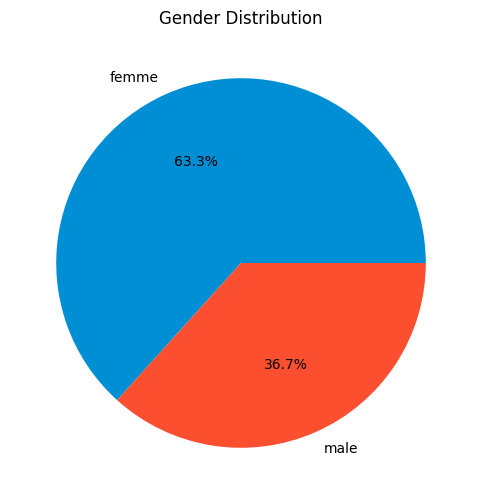

In [96]:
import matplotlib.pyplot as plt

# Count the occurrences of each gender value
gender_counts = df_person['gender_source_value'].value_counts()

# Create a pie chart
plt.figure(figsize=(6, 6))  # Set the figure size
colors = ['#008fd5', '#fc4f30']  # Set colors for male and femme
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', colors=colors)

# Add a title
plt.title('Gender Distribution')

# Display the chart
plt.show()

### 3.1.2 Age distribution

In [30]:
df_visit_age = df_visit.merge(df_person[['person_id','birth_datetime']], on='person_id', how='inner' )
df_visit_age['age'] = (df_visit_age['visit_start_datetime'] - df_visit_age['birth_datetime'])
df_visit_age['age'] = df_visit_age['age'].dt.days // 365

In [31]:
visit_age_summary = df_visit_age.groupby("age", as_index=False).person_id.count()

In [52]:
alt.Chart(visit_age_summary).mark_bar().encode(
    x='age:T',
    y='person_id:Q'
)

alt.Chart(...)

<a id="prepro_cond"></a>
## 3.2 Cancer patients

In [97]:
cancer_condition = {'C50','C500','C501','C502','C503','C504'}
df_cancer = df_condition[df_condition['condition_source_value'].isin(cancer_condition)]
df_cancer['drug_source_value'] = 'drugA'
print(f'le nombre de patients atteints de cancer est : {df_cancer.person_id.nunique()}')

le nombre de patients atteints de cancer est : 4327


c:\Users\gazze\anaconda3\envs\eds-tuto\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [94]:
#Import the helper functions
import sys
sys.path.append("../")
from plot_cancer_vs_control import plot_primary_kaplan

In [91]:
t_end_of_study = datetime.date(2025,12,1)

ValueError: Values must be numeric: no strings, datetimes, objects, etc.

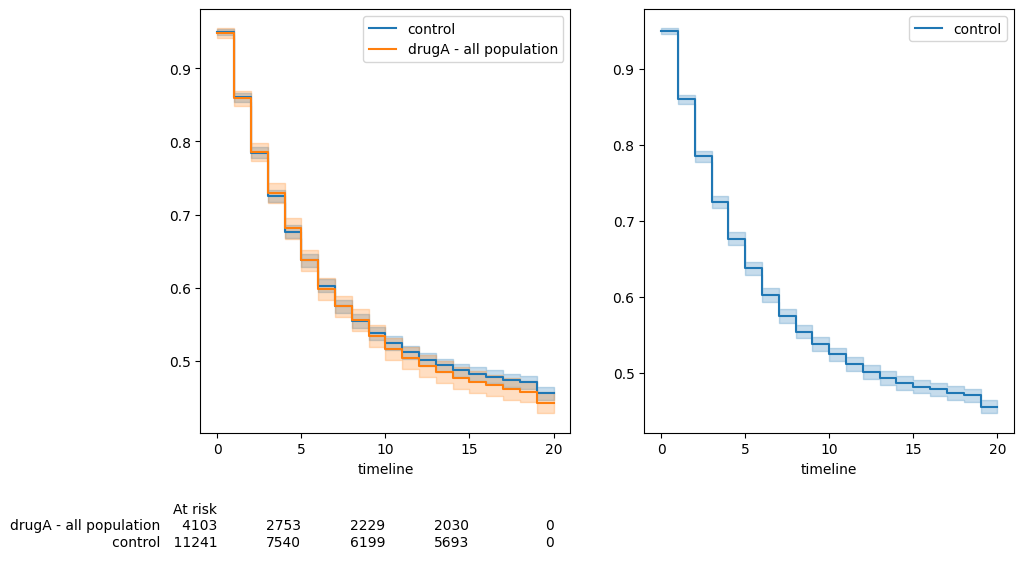

In [95]:
plot_primary_kaplan(df_person, [(df_visit, df_cancer, 'all population')], t_end_of_study)